# Model Training
- Author: Myles Dunlap


This notebook is used to train a model using a single configuration file. The steps in this notebook are used in the Python script.

# User Inputs

In [1]:
# Append the path for the custom modules
path_custom_modules = '../'

# Path to the YAML config. file
path_cfg = {'base_dir': '../cfgs',
            'filename': 'train-0-notebook.yaml'}

# Import Libraries and Modules

In [2]:
# Libraries
import os
import sys
from pathlib import Path
import gc
from transformers import AutoTokenizer
import torch

# Append Path to Custom Modules if Needed
sys.path.append('../')

# Custom Modules
from src.utils import (seed_everything,
                       load_cfg,
                       RunIDs,
                       debugger_is_active,
                       plot_perf_metric_to_disk)
from src.dataloading.load_data import LoadData
from src.dataloading.stratify import StratifyData
from src.dataloading.preprocess import PreprocessData
from src.dataloading.load_datasets import (CustomTextCollator,
                                           get_ds_dl,
                                           )
from src.training.single_fold import train_fold
from src.training.single_fold import train_fold

# Setup HF env. variables
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

# Load Config. and Setup

This section if focused on:
- loading the config. file,
- setting up directories for saving results, 
- seeding.

In [3]:
# Seed Everything
SEED = 42
seed_everything(seed=SEED)

# Get Device type for processing
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the configuration file
CFG = load_cfg(base_dir=Path(path_cfg['base_dir']),
               filename=path_cfg['filename'])

# Create directories for saving results and use unique Group ID
run_ids = RunIDs(test_folds=CFG.cv.val_folds,
                    num_folds=CFG.cv.num_folds,
                    save_dir=CFG.paths.save_results.base_dir,
                    save_results=CFG.paths.save_results.apply_metric)
run_ids.generate_run_ids()

# Print the group id and ids for each fold
print(f'Group ID: {run_ids.group_id}')
for fold_num in CFG.cv.val_folds:
    fold_id = getattr(run_ids.folds_id,
                      f'fold{fold_num}').run_id
    entire_id = f'{run_ids.group_id}-{fold_id}' 
    print((f'ID for Testing Fold #{fold_num}: '
           f'{fold_id}\n\tFull/Entire ID: {entire_id}'))

Group ID: fca00557
ID for Testing Fold #1: ba6c1f62
	Full/Entire ID: fca00557-ba6c1f62


# Workflow

The primary workflow begins in this section. Notice that prior to this section the key piece of information obtained is the configuration file. If multiple configurations needed to be processed this would be the entry point for those configuration files. For example, in the [training Python script](../scripts/train_model.py) for automating over various configuration files the workflow section is introduced with the `workflow` function.

Note: Only one fold of data will be analyzed in the notebook since this is for demonstration purposes. In the [training Python script](../scripts/train_model.py) all folds are trained.

In [4]:
# Load Data from Disk
load_data_file = LoadData(base_dir=CFG.paths.data.base_dir)
data = load_data_file.load(filename=CFG.paths.data.data)

# Stratify the Data
data = (StratifyData(technique=CFG.stratify.technique,
                     n_folds=CFG.cv.num_folds,
                     target=CFG.data_info.target)
        .stratify(df=data))

# Input and target field names
cols = CFG.data_info.source_fields + \
       [CFG.data_info.target, 'fold']

# Train a model for one validation fold
fold_num = CFG.cv.val_folds[0]

# Print information
display(data[cols].head(5))
print(f'Distribution of a Product for Each Fold')
print(f'Notice how the quantities are evenly distributed across folds')
display(data.groupby('Product').fold.value_counts()
        .sort_index().head(5))

,Consumer complaint narrative,ZIP code,Sub-issue,Product,fold
0,I currently have 5 direct loans serviced throu...,851XX,Trouble with how payments are being handled,Student loan,1
1,Performed XXXX procedures on my sons XXXX that...,761XX,Attempted to collect wrong amount,Debt collection,1
2,I have a 48 month lease with US Bank on a bran...,926XX,Problem while selling or giving up the vehicle,Vehicle loan or lease,1
3,On XX/XX/2019 i logged into my account to make...,30122,Company closed your account,Credit card or prepaid card,1
4,I recently checked my credit reports and saw t...,190XX,Their investigation did not fix an error on yo...,Vehicle loan or lease,1


Distribution of a Product for Each Fold
Notice how the quantities are evenly distributed across folds


Product                      fold
Credit card or prepaid card  1       400
                             2       400
                             3       400
                             4       400
                             5       400
Name: count, dtype: int64

In [5]:
# Split Data into Training and Validation
df_train = data.copy()[data.fold != fold_num].reset_index(drop=True)
df_val = data.copy()[data.fold == fold_num].reset_index(drop=True)
print('Number of Instances:')
print(f'\tTrain: {len(df_train):,}')
print(f'\tVal.: {len(df_val):,}')

Number of Instances:
	Train: 8,000
	Val.: 2,000


# Preprocess Target

Convert the text target into a label.

In [6]:
# Preprocessing Encoders
encoders = {}
for technique in CFG.preprocessing.apply_techniques:
    fields = getattr(CFG.preprocessing, technique).fields
    for col in fields:
        enc = PreprocessData(y=df_train[col].values,
                            technique=technique)
        encoders[col] = {'encoder': enc.encoder,
                        'technique': technique}
print(encoders)

{'Product': {'encoder': LabelEncoder(), 'technique': 'LabelEncoder'}}


# Tokenizer and Collator

A collator is an object that forms a batch of data by using a list of dataset elements as inputs. 

The module [load_datasets.py](../src/dataloading/load_datasets.py) has a custom collator class used here and it has several benefits such as:
- The data does **NOT** have to be tokenized prior to being passed to the PyTorch DataLoader class. Lots of online examples show the data already tokenized before going into a dataloader. Using the approach in this repo. means the text data is tokenized once a batch of data is processed in the DataLoader class and it allows for RAM usage to stay lower. For example, if your dataset exceeds the available RAM size then tokenizing all the data prior to the DataLoader (e.g., in the Dataset class) could become problematic.
- Using a custom collator enables dynamic padding over the batches. Later the maximum token length for a few batches will be printed to illustrate dynamic padding. This ultimately leads to faster processing of data as explained in this [HuggingFace YouTube video](https://www.youtube.com/watch?v=7q5NyFT8REg).

In [7]:
# Path to the model and tokenizer model card saved on disk
model_path = Path(CFG.model_tokenizer.base_dir) / CFG.model_tokenizer.name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower=True)

# Collator
collator = CustomTextCollator(tokenizer=tokenizer,
                              tokenizer_cfg=CFG.tokenizer)

# Datasets and DataLoaders
## Combine Mixed data type fields

In this [blob post by Chris McCormick](https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/) an interesting approach was taken to combine mixed data types which was to convert all categorical and numerical into the text feed into the LLM. This technique is used in this repository as shown in the `TrainDataset` class in the module [load_dataset.py](../src/dataloading/load_datasets.py). 

Another approach is only pass the unstructured text into the LLM, take its last layer output and combine with the other mixed data types into a dense layer. This type of approach seems more common and an example can be found on [Google Colab here](https://colab.research.google.com/drive/1F7COnwHqcLDPg_SS-oFgW3c2GPDWnS5Y#scrollTo=BAQFbN-wBpoz).

As a reminder this data has `categorical` and `unstructued` input fields that will be combined. More information on these variables can be found in the [eda.ipynb](./eda.ipynb) notebook and summarized below for convenience:

- Number of Independent variables = 3
    - `Consumer complaint narrative`: string of unstructured text and all instances are unique 
    - `ZIP code`: a categorical variable with high cardinality (i.e., > 20K unique values)
    - `Sub-issues`: a categorical variable with 63 unique values
- Dependent Variable = `Product`
    - `Product`: categorical with 5 unique values

In [8]:
# Train Dataset and Dataloader
(_,
train_dataloader) = get_ds_dl(df=df_train,
                              cfg=CFG,
                              tokenizer=tokenizer,
                              encoder=encoders[CFG.data_info.target]['encoder'],
                              collator=collator)
# Validation Dataset and Dataloader
(_,
val_dataloader) = get_ds_dl(df=df_val,
                            cfg=CFG,
                            tokenizer=tokenizer,
                            encoder=encoders[CFG.data_info.target]['encoder'],
                            collator=collator)

print(f'# of Training Samples: {len(df_train):,}')
print(f'# of Validation Samples: {len(df_val):,}')
print(f'Batch Size: {CFG.batch_size}')
print(f'{len(df_train):,} \ {CFG.batch_size:,} = {len(train_dataloader):,}')
print(f'Train DataLoader # of Iters: {len(train_dataloader):,}')
print(f'Val. DataLoader # of Iters: {len(val_dataloader):,}')

# Dynamic Padding of Maximum Token Lengths
print(f'\nDynamic Padding\n\tThe shape is [batch size, maximum token length]')
for i, inputs in enumerate(train_dataloader):
    if i > 10:
        break
    else:
        print((f'Batch {i + 1} of {len(train_dataloader):,}: '
               f'{inputs["input_ids"].shape}'))

# Display output from dataloader
print(f'Batch of data keys:\n{inputs.keys()}')

# of Training Samples: 8,000
# of Validation Samples: 2,000
Batch Size: 16
8,000 \ 16 = 500
Train DataLoader # of Iters: 500
Val. DataLoader # of Iters: 125

Dynamic Padding
	The shape is [batch size, maximum token length]
Batch 1 of 500: torch.Size([16, 512])
Batch 2 of 500: torch.Size([16, 512])
Batch 3 of 500: torch.Size([16, 512])
Batch 4 of 500: torch.Size([16, 512])
Batch 5 of 500: torch.Size([16, 512])
Batch 6 of 500: torch.Size([16, 512])
Batch 7 of 500: torch.Size([16, 512])
Batch 8 of 500: torch.Size([16, 512])
Batch 9 of 500: torch.Size([16, 512])
Batch 10 of 500: torch.Size([16, 512])
Batch 11 of 500: torch.Size([16, 512])
Batch of data keys:
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


# Learning Rate Finder and Scheduler

This section will look at useful tools to help with determining a learning rate before training the mode.

### Learning Rate Finder

A [PyTorch implementation](https://pypi.org/project/torch-lr-finder/) of the learning rate range test detailed in Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith and the tweaked version used by fastai.

In [9]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from torch import nn
from torch.optim import AdamW
from IPython.display import clear_output
from src.models.llm_multiclass import CustomModel
from src.training.optimizers import get_optimizer

# Load custom model
model = CustomModel(llm_model_path=model_path,
                    cfg=CFG.model,
                    num_classes=df_train[CFG.data_info.target].nunique())

# Set model on device
model.to(DEVICE)
clear_output()


# class TrainIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch):
#         return ({'input_ids': batch['input_ids'],
#                  'attention_mask': batch['attention_mask']},
#                 batch['labels'])
# train_data_iter = TrainIter(train_dataloader)

# # Learning Rate Finder
# lr_finder = LRFinder(model,
#                      AdamW(filter(lambda p: p.requires_grad, model.parameters())),
#                      nn.CrossEntropyLoss(),
#                      device="cuda")
# lr_finder.range_test(train_data_iter,
#                      start_lr=1.0e-8,
#                      end_lr=5.0e-4,
#                      num_iter=100,
#                      step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

A few notes in the above learning rate finder plot:
- The upper bound is ~3.0E-4 so learning rates above this will cause erratic behavior.
- The lower bound is <1.0E-4 where learning may not occur as quickly.
- This is a rather tight range for the learning rate and could be investigated further.

In experiments not shown in the notebook it was found that setting a learning rate >=1.0E-3 caused the model to not learn and converge to predicting a single class.

### Learning Rate Scheduler

Learning rate schedulers can be used to help an algorithm converge to a more optimal solution. Please refer to this references for more information and a visual representation of various learning rate schedules.
 - [Medium Article](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863)
 - [Kaggle Notebook](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

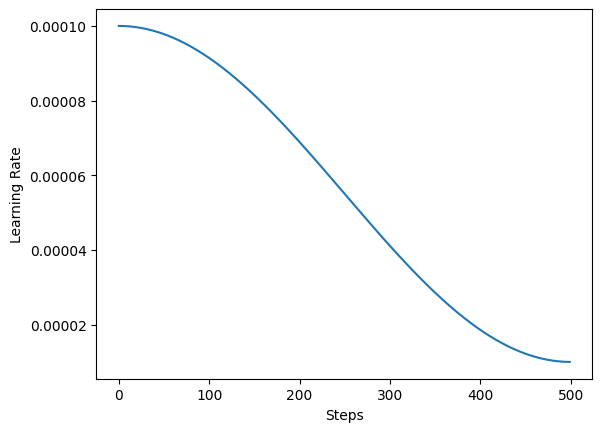

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt

# Optimizer
optimizer = get_optimizer(cfg=CFG.optimizer,
                          model=model)

# Learning rate scheduler
# scheduler = OneCycleLR(optimizer=optimizer,
#                        total_steps=total_steps,
#                        max_lr=CFG.optimizer.lr.max)

scheduler = CosineAnnealingLR(optimizer,
                              T_max=CFG.epochs * len(train_dataloader),
                              eta_min=CFG.lr_scheduler.CosineAnnealingLR.eta_min)
lr_value = []
steps = []
step_count = 0
for epoch in range(CFG.epochs):
    for batch_count in range(len(train_dataloader)):
        optimizer.step()
        lr_value.append(optimizer.param_groups[0]['lr'])
        steps.append(step_count)
        scheduler.step()
        step_count +=1

# Plot Learning Rate Schedule
plt.plot(steps, lr_value)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

In [13]:
import gc
# Set model to none to free GPU memory
model = None

# Clean up memory and variables
del (model, optimizer, scheduler, lr_value,
     steps, step_count,
    #  lr_finder, train_data_iter,
     )

# Release cached memory
torch.cuda.empty_cache()
_ = gc.collect()


# Train the Model

The process of training the model for a single fold of data is conducted by the module [single_fold.py](../src/training/single_fold.py).

The performance metrics `perf_metrics` are both the training and validation performance scores for f1, precision, recall, and loss at each epoch. 

### References
- Loss Functions
    - [Machine Learning Mastery](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
    - [Neptune AI Article](https://neptune.ai/blog/pytorch-loss-functions)
    - [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
    - Since this is a multi-class classification we can use nn.CrossEntropyLoss as the loss function. More elborate modules can be built for selecting and creating custom loss functions.

-   Performance Metrics
    - [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/) will be used for implementing performance metrics.
    - [F1-Score](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html)
    - [Precision]()
    - [Recall]()


In [11]:
# # Path to save model results
# model_save_path = getattr(run_ids.folds_id, f'fold{fold_num}').path

# # Training for a single fold
# perf_metrics = train_fold(train_dl=train_dataloader,
#                           val_dl=val_dataloader,
#                           cfg=CFG,
#                           device=DEVICE,
#                           n_classes=df_train[CFG.data_info.target].nunique(),
#                           model_save_path=model_save_path)

# Visualize Learning Curves

In [12]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# #compute the class weights
# train_labels = encoders['Product']['encoder'].transform(df_train['Product'])
# class_wts = compute_class_weight('balanced',
#                                  classes=np.unique(train_labels),
#                                  y=train_labels)

# # convert class weights to tensor
# weights= torch.tensor(class_wts, dtype=torch.float)
# weights = weights.to(DEVICE)